In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
# dataset_path = "/data/dataset_cartography/data/raw/st_ultra_full_proxy_cosine_fine-grained.jsonl"


# def load_processed_data(open_json):
#     with open(open_json, 'r') as file:
#         data = [json.loads(line) for line in file.readlines()]
#     return data

# data = load_processed_data(dataset_path)

high_corr_path = "/data/dataset_cartography/data/split/ultrafeedback-corr/high_corr.jsonl"
low_corr_path = "/data/dataset_cartography/data/split/ultrafeedback-corr/low_corr.jsonl"

def open_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

high_corr = open_data(high_corr_path)
low_corr = open_data(low_corr_path)

print(len(high_corr))
print(len(low_corr))


638
638


In [3]:
def make_pd(data):
    scores = []
    gpt_scores = []

    def sigmoid(x): return 1 / (1 + np.exp(-x))
                                
    scores = [item['scores'] for item in data]
    scores_avg = [(np.mean(prob)) for prob in scores]
    #scores_avg = [(gpt_scores[i]/np.mean(scores[i])) for i in range(len(data))]
    score_variance = [item['score_variance'] for item in data]
    correlation = [item['correlation'] for item in data]
    instruction = [item['instruction'] for item in data]
    gpt_inference = [item['gpt_inference'] for item in data]
    ann_scores = [np.array([comp['fine-grained_score'] for comp in item['completions']]) for item in data]



    response = []
    for item in data:
        response_str = ""
        for i in range(len(item['completions'])):
            response_str += item['completions'][i]['response']
            if i != len(item['completions']) - 1:
                response_str += "###"
        response.append(response_str)


    combined_df = pd.DataFrame({
        'score_avg': scores_avg,
        'scores': scores,
        'score_variance': score_variance,
        'correlation': correlation,
        'instruction': instruction,
        'response': response,
        'gpt_inference': gpt_inference,
        'ann_scores': ann_scores
    })
    return combined_df



In [4]:
high_corr_df = make_pd(high_corr)
low_corr_df = make_pd(low_corr)
print(len(high_corr_df))

638


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def print_pdf_corr(combined_df, low_corr, high_corr, filename, sample_num=10000):
    # 🔹 1. 커스텀 컬러맵 정의 (보라 → 파랑 → 초록 → 노랑)
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_palette", ["#6a0dad", "#20639B", "#3CAEA3", "#F6D55C"], N=256
    )

    # 🔹 2. 스타일 적용
    plt.style.use("ggplot")
    plt.rcParams['font.family'] = 'cmr10'
    plt.rcParams["axes.unicode_minus"] = False
    # 🔹 3. 그래프 그리기
    light_gray = "#f5f5f5"  # 아주 연한 회색 (Hex 코드 사용 가능)

    plt.figure(figsize=(10, 6))  # 전체 배경색 설정
    ax = plt.gca()
    ax.set_facecolor(light_gray)  # 그래프 내부 배경색 설정

    combined_df_sampled = combined_df[combined_df['score_avg'] > 0]  # 0.5 이상만 필터링
    if sample_num < len(combined_df_sampled):
        combined_df_sampled = combined_df_sampled.sample(n=sample_num, random_state=42)
    combined_df_sampled = combined_df_sampled[combined_df_sampled['score_avg'] > 0]  # 0.5 이상만 필터링
    print(len(combined_df_sampled))
    scatter = plt.scatter(
        combined_df_sampled['score_variance'], 
        combined_df_sampled['score_avg'], 
        c=combined_df_sampled['correlation'], 
        cmap=custom_cmap,  # 커스텀 컬러맵 적용
        s=12,  # 점 크기 줄이기
        edgecolors='none',  # 테두리 제거
        alpha=1,  # 적절한 투명도 적용
    )

    # 🔹 4. 컬러바 추가 (디자인 개선)

    scatter.set_clim(low_corr, high_corr)
    cbar = plt.colorbar(scatter)
    cbar.formatter.set_powerlimits((0, 0))  # 지수 표기 방지
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))  # 소수점 2자리
    cbar.update_ticks()  # 변경 사항 적용
    cbar.set_label('Preference Correlation', fontsize=25, fontweight='bold')
    cbar.ax.tick_params(labelsize=20)  # 컬러바 숫자 크기 증가

    # 🔹 5. 축 및 제목 스타일 조정
    plt.xlabel('Variance', fontsize=25, fontweight='bold', color='#333333')
    plt.ylabel('', fontsize=25, fontweight='bold', color='#333333')
    plt.title('', fontsize=16, fontweight='bold', color='#222222')

    # 🔹 x, y축 범위 고정
    plt.xlim(-0.01, 0.25)  # X축 범위 (예시: 0 ~ 1)
    plt.ylim(-0.01, 1)  # Y축 범위 (예시: 0 ~ 1)


    # 🔹 6. 그리드 및 디자인 마무리
    plt.grid(True, linestyle='-', linewidth=0.5, alpha=1, color='#dddddd')
    plt.tick_params(axis='both', labelsize=20)  # X, Y축 숫자 크기 증가

    plt.savefig(f"{filename}", dpi=300, bbox_inches='tight', facecolor='w')

    # 그래프 출력
    plt.savefig("scatter_plot.png", dpi=300, bbox_inches='tight', facecolor='w')
    plt.savefig("scatter_plot.pdf", dpi=300, bbox_inches='tight', facecolor='w')
    plt.show()


/tmp/ipykernel_617532/620686752.py:20: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipykernel_617532/620686752.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(scatter)


638


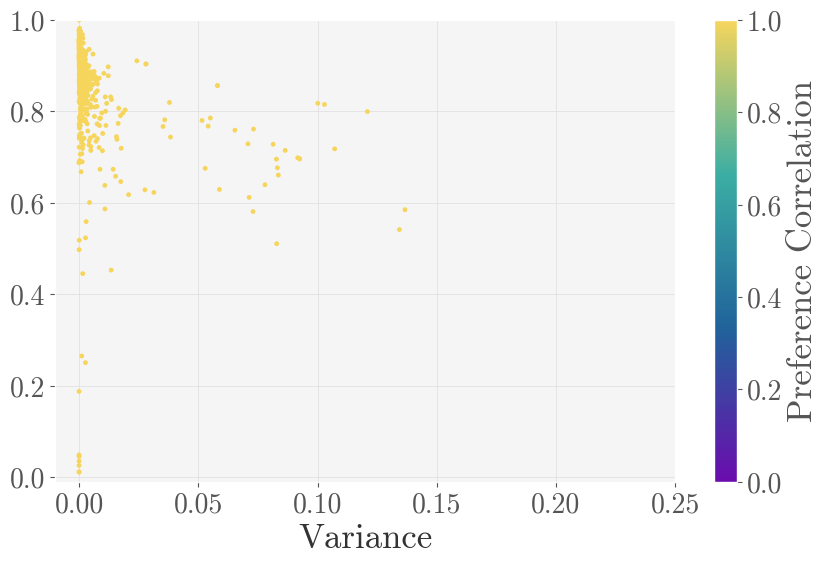

/tmp/ipykernel_617532/620686752.py:20: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipykernel_617532/620686752.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(scatter)


634


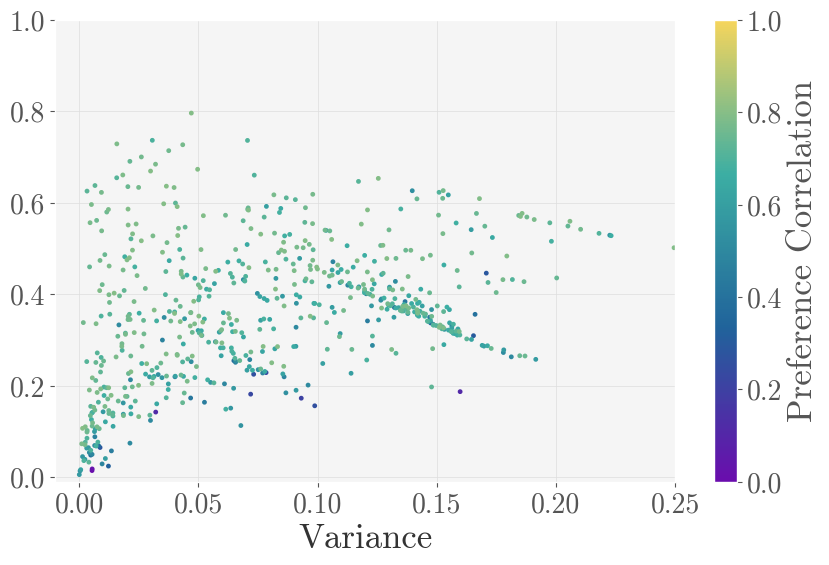

In [11]:
print_pdf_corr(high_corr_df, 0, 1, "ultra_high_corr.pdf")
print_pdf_corr(low_corr_df, 0, 1, "ultra_low_corr.pdf")

In [149]:


def filter_top(df, threshold_avg, threshold_var):
    # 기준선보다 높은 데이터 포인트 3개
    top = df[(df['score_avg'] > threshold_avg) & (df['score_variance'] < threshold_var)].nlargest(5, 'score_avg')
    print(top['correlation'])
    
    return top

def filter_bottom(df, threshold_avg, threshold_var):
    # 기준선보다 높은 데이터 포인트 3개
    top = df[(df['score_avg'] < threshold_avg) & (df['score_variance'] > threshold_var)].nlargest(1, 'score_avg')
    print(top['correlation'])
    
    return top
    
# 기준선 설정
threshold_avg = high_corr_df['score_avg'].median()
threshold_var = high_corr_df['score_variance'].median()

bottom_avg = low_corr_df['score_avg'].median()
bottom_var = low_corr_df['score_variance'].median()


# 필터링 실행
pd.set_option('display.max_colwidth', None)
top= filter_top(high_corr_df, threshold_avg, threshold_var)
bottom= filter_bottom(low_corr_df, bottom_avg, bottom_var)


# 가독성 좋은 결과 출력
def print_filtered_results(title, df):
    print(f"\n{'='*40}")
    print(f"📌 {title} ")
    print(f"{'='*40}")
    
    for i, (inst, resp, scores, ann_scores, gpt_inf) in enumerate(zip(df['instruction'], df['response'], df['scores'], df['ann_scores'], df['gpt_inference'])):
        print(f"\n[{i+1}] Instruction: {inst}")
        resp = resp.split("###")
        for count, resp in enumerate(resp):
            print(f"    🔹 Response{count+1}: {resp}")

        print(f"    🔹 Scores: {scores}")
        print(f"    🔹 Annotator Scores: {ann_scores}")
        print(f"    🔹 gpt_inference: {gpt_inf}")
        print("-" * 40)

# 결과 출력
print_filtered_results("Top 2 Data Points (High Correlation)", top)
print_filtered_results("Bottom 2 Data Points (Low Correlation)", bottom)

629    1.0
623    1.0
622    1.0
632    1.0
633    1.0
Name: correlation, dtype: float64
392    0.744673
Name: correlation, dtype: float64

📌 Top 2 Data Points (High Correlation) 

[1] Instruction: Definition: You will be given a topic and an argument. Decide the argument's stance towards that topic. The argument's stance is in favor or against the topic. If the argument supports that topic, answer with "in favor"; otherwise, if the argument opposes the topic, answer with "against".
Input: topic: Bombing Hiroshima and Nagasaki
argument: Bombing Japan was the lesser evil among the alternatives
Output:
    🔹 Response1: in favor
    🔹 Response2: in favor
    🔹 Response3: in favor
    🔹 Response4: in favor
    🔹 Scores: [1.000000238418579, 1.000000238418579, 1.000000238418579, 1.000000238418579]
    🔹 Annotator Scores: [4.5 4.5 4.5 4.5]
    🔹 gpt_inference: in favor
----------------------------------------

[2] Instruction: Q: You are given a sentence from a conversation between a human an